In [ ]:
import os

os.environ['MKL_NUM_THREADS'] = '1'
os.environ['OPENBLAS_NUM_THREADS'] = '1'

In [30]:
%matplotlib inline
import numpy as np
import pandas as pd
import pymc3 as pm
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter('ignore')

In [29]:
marathon_results = pd.read_csv('../data/marathon_results_2015.csv', index_col=0)[['Age', 'M/F', 'Official Time']]
marathon_results['time_hours'] = pd.to_timedelta(marathon_results['Official Time']).dt.seconds / 3600
marathon_results['female'] = marathon_results['M/F']=='F'
marathon_results = marathon_results[['Age', 'female', 'time_hours']].rename({'Age':'age'}, axis=1)
marathon_results.head()

,age,female,time_hours
0,25,False,2.154722
1,30,False,2.163333
2,29,False,2.172778
3,28,False,2.179722
4,32,False,2.180278


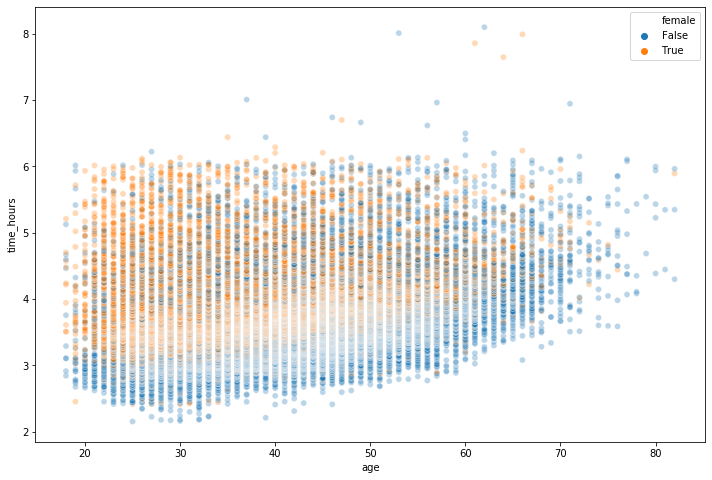

In [35]:
plt.figure(figsize=(12,8))
sns.scatterplot('age', 'time_hours', hue='female', data=marathon_results, alpha=0.3);

In [66]:
X, y = marathon_results.loc[marathon_results.female==True, ['age', 'time_hours']].values.T

In [67]:
with pm.Model() as marathon_model:

    ρ = pm.Exponential('ρ', 1)
    η = pm.Exponential('η', 1)

    K = η**2 * pm.gp.cov.ExpQuad(1, ρ)

    gp = pm.gp.MarginalSparse(cov_func=K, approx="FITC")

    # initialize 20 inducing points with K-means
    Xu = pm.gp.util.kmeans_inducing_points(10, X.reshape(-1,1))

    σ = pm.HalfCauchy("σ", beta=1)
    obs = gp.marginal_likelihood("obs", X=X.reshape(-1,1), Xu=Xu, y=y, noise=σ)

In [68]:
with marathon_model:
    
    trace_women = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, η, ρ]
Sampling 4 chains, 0 divergences: 100%|██████████| 6000/6000 [02:35<00:00, 38.69draws/s]


In [69]:
X_pred = np.linspace(20, 80)

with marathon_model:
    
    f_pred = gp.conditional('f_pred', X_pred.reshape(-1, 1))

In [71]:
with marathon_model:
    pred_samples = pm.sample_posterior_predictive(trace_women, vars=[f_pred], samples=1000)

100%|██████████| 1000/1000 [00:24<00:00, 40.02it/s]


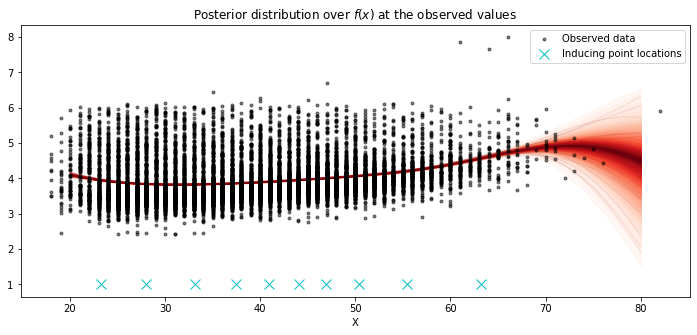

In [75]:
# plot the results
fig = plt.figure(figsize=(12,5)); ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist
plot_gp_dist(ax, pred_samples["f_pred"], X_pred);

# plot the data and the true latent function
plt.plot(X, y, 'ok', ms=3, alpha=0.5, label="Observed data");
plt.plot(Xu, np.ones(Xu.shape[0]), "cx", ms=10, label="Inducing point locations")

# axis labels and title
plt.xlabel("X");
plt.title("Posterior distribution over $f(x)$ at the observed values"); plt.legend();